In [32]:
import os 
import numpy as np
import pandas as pd
import torch
import pickle
from torch import nn
from torch.utils.data import *
import matplotlib.pyplot as plt
from torchvision.transforms import functional, Normalize, RandomRotation
from torch.optim import *
%matplotlib inline


In [33]:
root_path = '../datasets/cifar10/'
files = os.listdir(root_path)
"""
def read_data(file_name):
    with open(file_name,'rb') as f:
        dict_data = pickle.load(f,encoding='latin1')
    return dict_data

x_train = np.empty((0,3072),dtype=np.float32)
y_train = []
for f in files[1:-1]:
    print(f)
    train_batch = read_data(os.path.join(root_path,f))
    x_train = np.concatenate((x_train,train_batch['data']/np.float32(255)))
    y_train.extend(train_batch['labels'])
    #break
x_train = x_train.reshape(50000,3,32,32)
"""

"\ndef read_data(file_name):\n    with open(file_name,'rb') as f:\n        dict_data = pickle.load(f,encoding='latin1')\n    return dict_data\n\nx_train = np.empty((0,3072),dtype=np.float32)\ny_train = []\nfor f in files[1:-1]:\n    print(f)\n    train_batch = read_data(os.path.join(root_path,f))\n    x_train = np.concatenate((x_train,train_batch['data']/np.float32(255)))\n    y_train.extend(train_batch['labels'])\n    #break\nx_train = x_train.reshape(50000,3,32,32)\n"

In [34]:
#len(y_train)
#x_train.shape
#c1=x_train[2]
#c1.shape
#plt.imshow(x_train[0,:].reshape(1024,3).reshape(3,32,32).reshape(32,32,3))
#plt.imshow(c1.reshape(3,32,32).transpose(1,2,0))
#plt.imshow(c1.reshape(3,32,32).transpose(1,2,0))

#plt.imshow(x_train[2454].transpose(1,2,0))

In [35]:
"""
label_text = read_data(os.path.join(root_path,files[0]))['label_names']
dict_label_text={}
for idx, val in enumerate(label_text):
    dict_label_text[idx]=val
dict_label_text
"""

"\nlabel_text = read_data(os.path.join(root_path,files[0]))['label_names']\ndict_label_text={}\nfor idx, val in enumerate(label_text):\n    dict_label_text[idx]=val\ndict_label_text\n"

In [36]:
class ImageDataset(Dataset):
    ## transform and target_transform are specific to images.
    def __init__(self,root_path,is_train,mean_vec = None, transform=None, target_transform=None):
        self.root_path = root_path
        self.files = os.listdir(self.root_path)
        self.transform = transform
        self.target_transform = target_transform
        if is_train:
            self.x,self.y = self.read_train_data()
        else:
            self.x,self.y = self.read_test_data()
        
        if is_train:
            self.mean_vec = np.array([np.mean(self.x[:,0,:,:]),
                                      np.mean(self.x[:,1,:,:]),
                                      np.mean(self.x[:,2,:,:])])
        else:
            self.mean_vec = mean_vec
            
        self.std_vec = np.array([1.0,1.0,1.0])
        
        self.x = Normalize(self.mean_vec,self.std_vec)(torch.from_numpy(self.x))
        '''
        if is_train:
            self.x = self.augmentation()
            self.y = np.concatenate((self.y,self.y))
        '''
        
    def read_data_batch(self,file_name):
        with open(file_name,'rb') as f:
            dict_data = pickle.load(f,encoding='latin1')
        return dict_data
    
    def read_train_data(self):
        #x = np.empty((0,3072),dtype=np.float32)
        x = np.empty((0,3072),dtype=np.uint8)
        y = []
        data_size = 0
        for f in self.files[1:-1]:
            train_batch = self.read_data_batch(os.path.join(self.root_path,f))
            #x = np.concatenate((x,train_batch['data']/np.float32(255)))
            x = np.concatenate((x,train_batch['data']))/np.float32(1)
            y.extend(train_batch['labels'])
        data_size = x.shape[0]
        x = x.reshape(data_size,3,32,32)
        return x,np.array(y)
    
    def read_test_data(self):
        data_size = 0
        test_batch = self.read_data_batch(os.path.join(self.root_path,self.files[-1]))
        x = test_batch['data']/np.float32(1)
        y = test_batch['labels']
        data_size = x.shape[0]
        x = x.reshape(data_size,3,32,32)
        return x,np.array(y)
        
    def augmentation(self):
        num_images = self.x.size(0)
        rotater = RandomRotation((0,180))
        rotated_imgs = rotater(self.x)#torch.tensor([rotater(i) for i in self.x])
        return torch.cat((self.x,rotated_imgs))
        
    def __len__(self):
        return self.y.shape[0]
    
    def __getitem__(self,idx):
        return self.x[idx,:,:,:], self.y[idx]
    
   # .to_tensor


In [37]:
train_dataset = ImageDataset(root_path, is_train = True)
test_dataset = ImageDataset(root_path, mean_vec = train_dataset.mean_vec, is_train = False)
train_dataloader = DataLoader(train_dataset, batch_size = 128, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size = 128, shuffle=True)

In [38]:
#plt.imshow(train_dataset[0][0].transpose(1,2,0))
#len(train_dataset)

#resnet_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
#resnet_model

In [39]:
class customCNN1(nn.Module):
    def __init__(self):
        super(customCNN1,self).__init__()
        self.conv_pool_input_stack = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=(3,3), stride=1, padding=1),
            nn.BatchNorm2d(32), # 32,32,32 -C,H,W
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(3,3),stride=1,padding=1,dilation=1),)
        
        self.reset_block = nn.Sequential(
            #resnet block
            nn.Conv2d(32, 32, kernel_size=(3,3), stride=1, padding=1),
            nn.BatchNorm2d(32), # 32,32,32 -C,H,W
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=(3,3), stride=1, padding=1),)
        # Add x here
        self.relu_after_resnet = nn.ReLU()
        
        self.conv_after_resnet = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=(3,3), stride=1, padding=1),
            nn.BatchNorm2d(64), # 64,16,16
            nn.ReLU(),# 128,32,32 -C,H,W
            nn.MaxPool2d(kernel_size=(4,4),stride=2,padding=1,dilation=1),)
        
        self.final_fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16*16*64, 512),
            nn.ReLU(),
            nn.Linear( 512,10),
        )

        
    def forward(self,x):
        prep_input = self.conv_pool_input_stack(x)
        resnet_output = self.reset_block(prep_input)
        resnet_relu_output = self.relu_after_resnet (resnet_output+prep_input)
        conv_after_resnet_output = self.conv_after_resnet(resnet_relu_output)
        logits = self.final_fc(conv_after_resnet_output)
        return logits

In [40]:
"""
conv1 = nn.Conv2d(3, 64, kernel_size=(3,3), stride=1, padding=1)
x = torch.rand((3,32,32), dtype=torch.float)
x_conv = conv1(x)
x_conv.shape

pool1 = nn.MaxPool2d(kernel_size=(3,3), 
                  stride=1, 
                  padding=1, 
                  dilation=1)
x = torch.rand((64,32,32), dtype=torch.float)
x_pool = pool1(x)
x_pool.shape
"""

def train(model, optimizer, loss_fn, train_dataloader,train_loss):
    model.train()
    for batch, (x_train,y_train) in enumerate(train_dataloader):
        x_train = x_train.cuda()
        x_train.to(device)
        y_train = y_train.cuda()
        y_train.to(device)
        #x_train = torch.from_numpy(x_train).float().to(device)
        logits = model(x_train)
        # model.to(device)
        loss_val = loss_fn(logits, y_train)
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()
        if batch%100==0:
            print("Batch Loss: ", loss_val.item())
            train_loss.append(loss_val.item())
    return model, train_loss

def test(model, test_dataloader,loss_fn,test_loss,test_acc):
    model.eval()
    total_loss = 0
    total_acc = 0
    num_batches = len(test_dataloader)
    with torch.no_grad():
        for x_test, y_test in test_dataloader:
            x_test = x_test.cuda()
            y_test = y_test.cuda()
            logits = model(x_test)
            loss_val = loss_fn(logits, y_test)
            total_loss += loss_val
            total_acc += (logits.argmax(1)==y_test).type(torch.float).sum().item()
    print("Batch Loss Val: ", total_loss.item()/num_batches)
    
    print("Accuracy: ", total_acc)
    test_loss.append(total_loss.item())
    test_acc.append(total_acc)
    return test_loss,test_acc
        

In [41]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = customCNN1().to(device)
loss_fn = nn.CrossEntropyLoss()
#optimizer = Adam(model.parameters(),lr=0.0008,weight_decay=0.02)
optimizer = Adam(model.parameters(),lr=0.00087,weight_decay=0.0039)
print(device)

cuda


In [42]:
epochs = 60
train_loss = []
test_loss = []
test_acc = []
for epoch in range(epochs):
    print("Epoch: ", epoch)
    model,train_loss = train(model, optimizer, loss_fn, train_dataloader,train_loss)
    test_loss,test_acc = test(model, test_dataloader,loss_fn,test_loss,test_acc)

Epoch:  0
Batch Loss:  2.3656492233276367
Batch Loss:  1.6417980194091797
Batch Loss:  1.2579346895217896
Batch Loss:  1.1915380954742432
Batch Loss Val:  1.0902693543253066
Accuracy:  6128.0
Epoch:  1
Batch Loss:  0.9978266954421997
Batch Loss:  1.2804617881774902
Batch Loss:  1.0834985971450806
Batch Loss:  1.0194426774978638
Batch Loss Val:  1.0075245145000988
Accuracy:  6466.0
Epoch:  2
Batch Loss:  0.8218609094619751
Batch Loss:  1.0153368711471558
Batch Loss:  0.8910574913024902
Batch Loss:  0.8214600682258606
Batch Loss Val:  0.8887757892850079
Accuracy:  6850.0
Epoch:  3
Batch Loss:  0.7560036778450012
Batch Loss:  0.8554032444953918
Batch Loss:  0.6467968821525574
Batch Loss:  0.945427656173706
Batch Loss Val:  0.8048727301102651
Accuracy:  7139.0
Epoch:  4
Batch Loss:  0.8196675777435303
Batch Loss:  0.8467905521392822
Batch Loss:  0.8675464391708374
Batch Loss:  0.6808727979660034
Batch Loss Val:  0.8377279933494858
Accuracy:  7047.0
Epoch:  5
Batch Loss:  0.7884818315505981

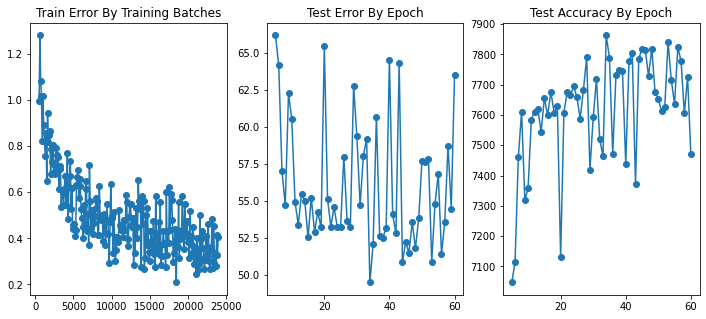

In [43]:
fig, ax = plt.subplots(1,3)
train_batches = [i for i in range(100, 100*(len(train_loss)+1),100)]
test_epochs = [i for i in range(1,len(test_loss)+1)]
ax[0].plot(train_batches[4:], train_loss[4:])
ax[0].scatter(train_batches[4:], train_loss[4:])
ax[0].set_title('Train Error By Training Batches')
ax[1].plot(test_epochs[4:],test_loss[4:])
ax[1].scatter(test_epochs[4:],test_loss[4:])
ax[1].set_title('Test Error By Epoch')
ax[2].plot(test_epochs[4:], test_acc[4:])
ax[2].scatter(test_epochs[4:], test_acc[4:])
ax[2].set_title('Test Accuracy By Epoch')
fig.set_figwidth(12)
fig.set_figheight(5)
plt.show()